In [1]:
import os
import sys

import scipy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import pandas as pd
import matplotlib.pyplot as plt

os.environ["CUBLAS_WORKSPACE_CONFIG"]=":4096:8"

np.random.seed(42)
C0 = '#005AFF'
C1 = '#FF4B00'

if "../scripts" not in sys.path:
    sys.path.append("../scripts")
    
plt.rcParams["font.size"] = 12
%matplotlib inline
%config InlineBackend.figure_formats = ['png']
%load_ext autoreload
%autoreload 2

# Prepare the data by solve Stuart Landau Equation.

In [2]:
from scipy.integrate import solve_ivp
dim_x = 3
omega = 1.9
mu = 1e0
epoch = 50
N = 500
T = 2 * np.pi / omega * 10
delta_t = T / N


b_param = .1
a_param = omega + b_param
c_param = .4

def exponential_decay(t, y):
    r_sq = np.sum(y ** 2)
    xy_sqr = np.sqrt(np.sum(y[:2] ** 2))
    y0 = y[0] - a_param * y[1] - r_sq * (y[0] - b_param *  y[1]) \
        + c_param * y[0] * y[2] ** 2 / xy_sqr / np.sqrt(r_sq)
    
    y1 = a_param * y[0] + y[1] - r_sq * (b_param * y[0] + y[1]) \
        + c_param * y[1] * y[2] ** 2 / xy_sqr / np.sqrt(r_sq)
    
    y2 = (1 - r_sq - c_param * xy_sqr / np.sqrt(r_sq)) * y[2]
    return np.asarray([y0, y1, y2])

data = []
times = []
for i in range(epoch):
    x0 = np.random.randn(dim_x) * 1.0
    # x0 = np.array([1., 1.0, 0.1])
    
    t = np.arange(N) * delta_t
    sol = solve_ivp(exponential_decay, [0, T], y0=x0, t_eval=t)
    if sol.success:
        data.append(sol.y.T)
        times.append(sol.t.reshape(-1, 1))
    else:
        print("failure", x0)
        
data = np.stack(data, axis=0)
times = np.stack(times, axis=0)

# Leaning

In [3]:
trajectory = torch.tensor(data, dtype=torch.float32, device="cuda")
trajectory = trajectory.cuda()
dt = np.diff(times, axis=1).mean()

print("traj.shape", trajectory.shape, "dt", dt)

traj.shape torch.Size([50, 500, 3]) dt 0.06613879270715356


In [4]:
from phase_amplitude_reduction import PADynTrainer

dim_obs = trajectory.shape[-1]
recon_loss_coef = torch.ones(dim_obs, dtype=trajectory.dtype, device=trajectory.device) * 1.0

trainer = PADynTrainer(
    dim_latent=3,
    dim_obs=dim_obs,
    hidden_layer_size=[256, 256],
    delta_t=dt,
    device="cuda",
    num_iters=5000,
    learning_rate=1e-3,
    discount_gamma=0.999,  # 0.99 ** 50 ~ 0.6
    latent_noise=1e-5,
    natural_freq=omega / (2 * np.pi),
    amplitude_range=[0.1, 1.0],
    recon_loss_coef=recon_loss_coef
)

In [11]:
# trainer.learn(trajectory[:trajectory.shape[0] // 2, :trajectory.shape[1] // 2])
# trainer.save("../data/stuart-landau-model.pt")
model = trainer.load("../data/stuart-landau-model.pt")
model.to("cuda")
trainer =  model

/export/yamamori-dp/yamamori/work/phase-reduction-based-imitation-learning/notebooks/../scripts/phase_amplitude_reduction.py:318: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

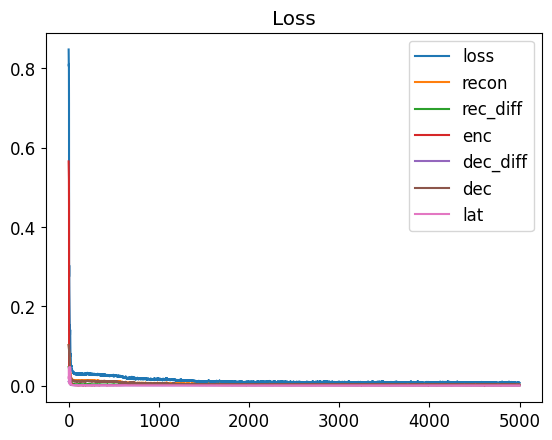

In [12]:
loss = np.array([x.detach().cpu() for x in trainer.record["loss"]])
loss_recon = np.array([x.detach().cpu() for x in trainer.record["loss_recon"]])
loss_rec_diff = np.array([x.detach().cpu() for x in trainer.record["loss_rec_diff"]])
loss_enc = np.array([x.detach().cpu() for x in trainer.record["loss_enc"]])
loss_dec_diff = np.array([x.detach().cpu() for x in trainer.record["loss_dec_diff"]])
loss_dec = np.array([x.detach().cpu() for x in trainer.record["loss_dec"]])
loss_lat = np.array([x.detach().cpu() for x in trainer.record["loss_lat"]])
plt.plot(loss, label="loss")
plt.plot(loss_recon, label="recon")
plt.plot(loss_rec_diff, label="rec_diff")
plt.plot(loss_enc, label="enc")
plt.plot(loss_dec_diff, label="dec_diff")
plt.plot(loss_dec, label="dec")
plt.plot(loss_lat, label="lat")
plt.legend()
plt.title("Loss")
plt.show()

# Predict by Model

In [13]:
T = data.shape[1]
traj = torch.tensor(data, dtype=torch.float32, device="cuda")
obs_pred, latent = trainer.rollout(traj[:, 0:1], T, predict=True)
latent = latent.detach().cpu()
obs_pred = obs_pred.detach().cpu().numpy()

with torch.no_grad():
    latent_enc = trainer.enc(traj)
    obs_rec= trainer.dec(latent_enc)
    obs_rec = obs_rec.detach().cpu().numpy()
    latent_enc = latent_enc.detach().cpu().numpy()

# RMSE Score with test data

In [14]:
print("data shape:", obs_pred.shape, data.shape)
print("train size:{}, test size:{}".format(data.shape[0] // 2, data.shape[0] // 2))
num_data = data.shape[0]
norm = np.square(obs_pred[num_data // 2:] - data[num_data // 2:]).sum(axis=2)
RMSE = np.sqrt(norm.mean(axis=1)).mean(axis=0)
print(f"test RMSE:{RMSE:.5f}")

data shape: (50, 500, 3) (50, 500, 3)
train size:25, test size:25
test RMSE:0.08518


# Plot predict trajectory and compare the original data

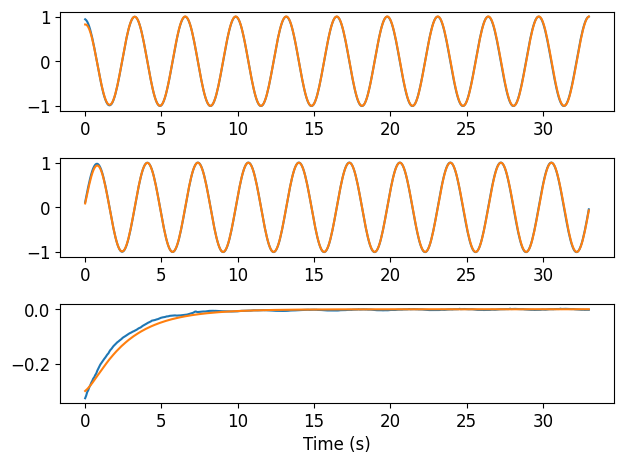

In [15]:
idx = num_data // 2
for i in range(data.shape[-1]):
    plt.subplot(3, 1, i + 1)
    plt.plot(times[idx], obs_pred[idx, :, i], label="pred")
    plt.plot(times[idx], data[idx, :, i], label="pred")
plt.xlabel("Time (s)")
plt.tight_layout()
plt.show()

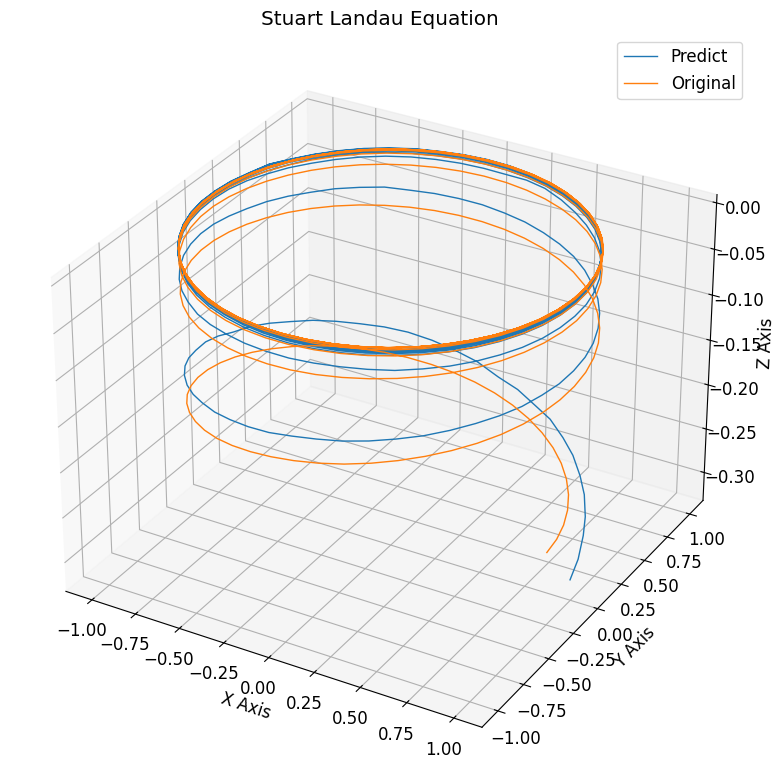

In [16]:
ax = plt.figure(figsize=(8, 8)).add_subplot(projection='3d')

ax.plot(*obs_pred[idx].T, lw=1.0, label="Predict")
ax.plot(*data[idx].T, lw=1.0, label="Original")
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Stuart Landau Equation")
plt.legend()
plt.tight_layout()
plt.show()